In [1]:
"""
GRASP new design calculation for GRAMS
@aurthor Jiancheng Zeng
@Oct 20 2021
"""

'\nGRASP new design calculation for GRAMS\n@aurthor Jiancheng Zeng\n@Oct 20 2021\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
from numpy import array
import pandas as pd
import math
import time
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

In [3]:
"""
Select by name of the column
---------------------
"""
title = ["eventID", "trackID", "parentID", "particleID", "copyNb1 (mother volume)", "copyNb", "material", "time (ns)", "energy(MeV)", "energy deposit(MeV)", "parent process name", "process name", "px (MeV/c)", "py (MeV/c)", "pz (MeV/c)", "step length (cm)", "x (cm)", "y (cm)", "z (cm)"]

"""
Read data from total data file
--------------------
"""
print("Reading data ...")
#data = pd.read_table("/Users/jiancheng/GRAMS/Toy Model/Machine Learning/210824_anti_proton_250MeV_Lin.dat")    #get data file
data = np.array(pd.read_table("/Users/jiancheng/GRAMS/data/rawdata/ORI_Stop_anti_He3_1e9_Ene_0_1500.dat"))
print("finish reading data!")

"""
select analysis particle type
"""
Particle_Type = -1000020030    #[antiproton]-2212    [antideuteron]-1000010020    [antiHe3]-1000020030

"""
Analyzed variables
"""
index = []    #Event number
TOF_out_E = []    #energy deposit on the outer TOF
TOF_out_T = []    #time reach the outer TOF 
TOF_in_E = []    #energy deposit on the inner TOF
TOF_in_T = []    #time reach the inner TOF
angle = []    #angle read in between inner and outer TOF
distance = []    #distance in between inner and outer TOF
PeD = []    #distance travel inside LArTPC
PeD_z = []    #penetration depth on vertical direction inside LArTPC
TOF_out_side = []    #distance on the side from top of outer TOF up layer
Init_Energy = []    #initial energy
Stop_Events = []    #[1]for stop events, [0]for annihilation in flight events
Nevent = -1

print("Modifing data ...")
for i in range(len(data[:,0])-1):
#for i in range(27):
    Nevent = Nevent + 1
    if(data[i][0] != data[i+1][0]):
        for k in range(Nevent+1):
            #print(float(data[i-Nevent+k][3]) == float(Particle_Type))
            #if(str(data[i-Nevent+k][6]) == 'LAr' and float(data[i-Nevent+k][3]) == float(Particle_Type) and str(data[i][8]) == str(data[i][9])):    #Stop events only
            if(str(data[i-Nevent+k][6]) == 'LAr' and float(data[i-Nevent+k][3]) == float(Particle_Type)):    #including stop events and annihilation in flight events
                event_in = 0    #temperary variable tracking first inner TOF hit point
                event_out = 0    #temperary variable tracking first outer TOF hit point
                tempin = 0    #temperary variable tracking inner TOF energy deposit
                tempout = 0    #temperary variable tracking outer TOF energy deposit
                d_from_top = 0    #temperary variable tracking side hit distance from top
                for m in range(k):
                    if(int(data[i-Nevent+m][5]) == -10000 or int(data[i-Nevent+m][5]) == -10001 or int(data[i-Nevent+m][5]) == -10002 or int(data[i-Nevent+m][5]) == -10003 or int(data[i-Nevent+m][5]) == -10004 or int(data[i-Nevent+m][5]) == -10005 and float(data[i-Nevent+m][3]) == float(Particle_Type)):    #accumulate energy deposit inside outer TOF
                    #if(int(data[i-Nevent+m][5]) == -11004 and float(data[i-Nevent+m][3]) == float(Particle_Type)):
                        tempout = tempout + float(data[i-Nevent+m][9])
                        if(int(data[i-Nevent+m-1][5]) != -10000 and int(data[i-Nevent+m-1][5]) != -10001 and int(data[i-Nevent+m-1][5]) != -10002 and int(data[i-Nevent+m-1][5]) != -10003 and int(data[i-Nevent+m-1][5]) != -10004 and int(data[i-Nevent+m-1][5]) != -10005 and data[i-Nevent+m][6] == 'Plastic'):    #find first outer TOF hit point
                            event_out = m
                            if(int(data[i-Nevent+m][5]) == -10002 or int(data[i-Nevent+m][5]) == -10003 or int(data[i-Nevent+m][5]) == -10004 or int(data[i-Nevent+m][5]) == -10005):    #find side hit distance from top info, if not applicable, this will be 0
                                d_from_top = 170.0 - float(data[i-Nevent+m][18])
                    #elif(int(data[i-Nevent+m][5]) == -10000 or int(data[i-Nevent+m][5]) == -10005 and float(data[i-Nevent+m][3]) == float(Particle_Type)):
                    if(int(data[i-Nevent+m][5]) == -11000 or int(data[i-Nevent+m][5]) == -11001 or int(data[i-Nevent+m][5]) == -11002 or int(data[i-Nevent+m][5]) == -11003 or int(data[i-Nevent+m][5]) == -11004 or int(data[i-Nevent+m][5]) == -11005 and float(data[i-Nevent+m][3]) == float(Particle_Type)):    #accumulate energy deposit inside inner TOF
                        tempin = tempin + float(data[i-Nevent+m][9])
                        if(int(data[i-Nevent+m-1][5]) != -11000 and int(data[i-Nevent+m-1][5]) != -11001 and int(data[i-Nevent+m-1][5]) != -11002 and int(data[i-Nevent+m-1][5]) != -11003 and int(data[i-Nevent+m-1][5]) != -11004 and int(data[i-Nevent+m-1][5]) != -11005 and data[i-Nevent+m][6] == 'Plastic'):    #find first inner TOF hit point
                            event_in = m
                if(tempin != 0 and tempout != 0):
                    #theta0 = np.arctan((210 - float(selection[i][0][18]))/np.sqrt((float(selection[i][0][17])-0) ** 2 + (float(selection[i][0][16])-0) ** 2))    #initial angle
                    theta = np.arctan(np.sqrt((float(data[i-Nevent+event_out][17])-float(data[i-Nevent+event_in][17])) ** 2 + (float(data[i-Nevent+event_out][16])-float(data[i-Nevent+event_in][16])) ** 2)/(float(data[i-Nevent+event_out][18])-float(data[i-Nevent+event_in][18])))    #angle in between TOF
                    distance_temp = np.sqrt((float(data[i-Nevent+event_out][16]) - float(data[i-Nevent+event_in][16])) ** 2 + (float(data[i-Nevent+event_out][17]) - float(data[i-Nevent+event_in][17])) ** 2 + (float(data[i-Nevent+event_out][18]) - float(data[i-Nevent+event_in][18])) ** 2)    #distance in between TOF
                    PeD_temp = np.sqrt((float(data[i][16])-float(data[i-Nevent+k][16]))**2+(float(data[i][17])-float(data[i-Nevent+k][17]))**2+(float(data[i][18])-float(data[i-Nevent+k][18]))**2)    #Penetration distance inside LArTPC
                    TOF_out_E.append(tempout)
                    TOF_in_E.append(tempin)
                    index.append(data[i-Nevent+k][0])
                    TOF_out_T.append(data[i-Nevent+event_out][7])
                    TOF_in_T.append(data[i-Nevent+event_in][7])
                    angle.append(theta)
                    distance.append(distance_temp)
                    PeD.append(PeD_temp)
                    PeD_z.append(10-float(data[i][18]))
                    TOF_out_side.append(d_from_top)
                    Init_Energy.append(data[i-Nevent][8])
                    if(str(data[i][8]) == str(data[i][9])):
                        Stop_Events.append(1)
                    else:
                        Stop_Events.append(0)
                    Nevent = -1
                break
        Nevent = -1
    print("TOF data process:"+str(int(100*i/len(data[:,0])))+"%", end='\r')

print("\n identification:finished!")

"""
modify data format
"""
index = array([float(i) for i in index])
time = array([float(i) for i in TOF_in_T]) - array([float(i) for i in TOF_out_T])
TOF_out_E = array([float(i) for i in TOF_out_E])
TOF_in_E = array([float(i) for i in TOF_in_E])
angle = array([float(i) for i in angle])
distance = array([float(i) for i in distance])
PeD = array([float(i) for i in PeD])
PeD_z = array([float(i) for i in PeD_z])
TOF_out_side = array([float(i) for i in TOF_out_side])
Init_Energy = array([float(i) for i in Init_Energy])
Stop_Events = array([float(i) for i in Stop_Events])

"""
Vector title: [0]Event number/[1]energy deposit on the outer TOF/[2]energy deposit on the inner TOF/[3]time in between TOF/[4]angle in between TOF/[5]distance in between TOF/[6]distance travel inside LArTPC/[7]penetration depth on z/[8]distance on the side/[9]initial energy/[10]event type
"""
Result_Vector = np.array([index, TOF_out_E, TOF_in_E, time, angle, distance, PeD, PeD_z, TOF_out_side, Init_Energy, Stop_Events]).transpose()

"""
Save analysis vector
"""
with open("/Users/jiancheng/GRAMS/data/TOF/ORI_Stop_anti_He3_1e9_Ene_0_1500_vector.txt", "w") as f:    #input file
#with open("/Users/jiancheng/CloudDocuments/Documents/Github/GRAMS/GRAMS_2021/output/TOF/test.txt", "ab") as f:    #test run
    #f.write(b"\n")
    np.savetxt(f, Result_Vector)
print("finished!")

Reading data ...
finish reading data!
Modifing data ...
TOF data process:99%
 identification:finished!
finished!


'\nprint("Number of events less than 1.3m:"+str(len(PeD[PeD<130])/len(PeD)))\nprint("Number of events less than 1.2m:"+str(len(PeD[PeD<120])/len(PeD)))\nprint("Number of events less than 1.1m:"+str(len(PeD[PeD<110])/len(PeD)))\nprint("Number of events less than 1.0m:"+str(len(PeD[PeD<100])/len(PeD)))\nprint("Number of events less than 0.9m:"+str(len(PeD[PeD<90])/len(PeD)))\nprint("Number of events less than 0.8m:"+str(len(PeD[PeD<80])/len(PeD)))\nprint("Number of events less than 0.7m:"+str(len(PeD[PeD<70])/len(PeD)))\n'

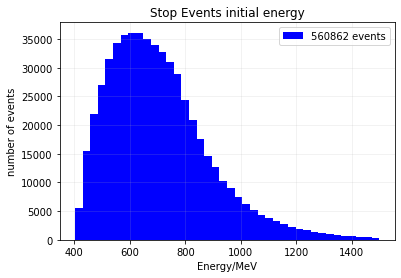

In [6]:
plt.hist(Init_Energy[Stop_Events==1], bins = 40, label = "%d events"%len(Init_Energy[Stop_Events==1]), color = 'b')

plt.title('Stop Events initial energy')
plt.xlabel('Energy/MeV')
plt.ylabel('number of events')
plt.legend(loc='best')
#plt.axis([0, 20, 0, 10])
plt.grid(alpha = 0.2)

"""
print("Number of events less than 1.3m:"+str(len(PeD[PeD<130])/len(PeD)))
print("Number of events less than 1.2m:"+str(len(PeD[PeD<120])/len(PeD)))
print("Number of events less than 1.1m:"+str(len(PeD[PeD<110])/len(PeD)))
print("Number of events less than 1.0m:"+str(len(PeD[PeD<100])/len(PeD)))
print("Number of events less than 0.9m:"+str(len(PeD[PeD<90])/len(PeD)))
print("Number of events less than 0.8m:"+str(len(PeD[PeD<80])/len(PeD)))
print("Number of events less than 0.7m:"+str(len(PeD[PeD<70])/len(PeD)))
"""

In [5]:
print(len(time))

1471381
